# Overview

In this post I implement a simple pairs trading strategy based on bivariate cointegration tests in the selection phase on NASDAQ 100 equities. The selection phase will be based on data from 2018-2021. The trading & evaluation phase will be from 2021-2023. I then analyze further trends between cointegration, returns and sector in the data. The repo is here. No third party backtesting or analysis libraries were used.

Certain implementation aspects were not addressed that would make such a strategy impractical live:

* Survivorship Bias – The in-sample period starts from 2018 so I should have simulated the strategy using the historical index constituents of the NASDAQ 100 in 2018, but finding these was surprisingly non-trivial.
* Transaction Costs – The backtest does not simulate broker commissions.
* Liquidity, Market Impact & Scaling – The backtest does not simulate market impact. Low liquidity would mean trades filling at execution prices too far from the theoretical order price, especially with larger notionals.
* Spurious/Decaying Cointegration – Cointegration could be spurious or decay quickly.

NOTE - This notebook is just the code snippets and may seem disjointed. For the actual commentary, please see my blogpost [here](https://ryan-chew.com/quant_pairs_trade.html).

# Data Prep and Pickles

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
import pickle
import pandas_datareader as pdr
import datetime
import scipy.stats as s

warnings.filterwarnings('ignore')

in_sample_start = '2018-01-01'
out_sample_start = '2021-01-01'
out_sample_end = '2023-03-01'

def get_closing_prices(tickers, date_start, date_end):
    prices = yf.download(tickers, start=date_start, end=date_end)['Adj Close']
    return prices.dropna(axis=1)

def get_volume(tickers, date_start, date_end):
    prices = yf.download(tickers, start=date_start, end=date_end)['Volume']
    return prices.dropna(axis=1)

def split(df, in_sample_start, out_sample_start):
    return df[(df.index >= pd.to_datetime(in_sample_start)) & (df.index <= pd.to_datetime(out_sample_start))], df[(df.index >= pd.to_datetime(out_sample_start))]

In [2]:
# stock_tickers = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].Ticker.values.tolist()
# ticker_sectors = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4][['Ticker','GICS Sector']]

stock_tickers = pd.read_pickle(r'data\tickers')
sector_map = pd.read_pickle(f'data\sector_map')
sector_index = pd.read_pickle(f'data\sector_index')

# stocks = get_closing_prices(stock_tickers,in_sample_start,out_sample_end).round(3)
# ndx = yf.download('^NDX',in_sample_start,out_sample_end)['Adj Close'].round(3)
# vol = get_volume(stock_tickers,in_sample_start,out_sample_end).round(3)

# ticker_sectors = ticker_sectors[ticker_sectors.Ticker.isin(stocks.columns)]
# sector_index = ticker_sectors.groupby('GICS Sector').value_counts().index
# sector_map = ticker_sectors.set_index('Ticker').to_dict()['GICS Sector']

# stocks.to_pickle('data\qm_stocks')
# ndx.to_pickle(r'data\ndx')
# vol.to_pickle(r'data\qm_liquidity')
# pickle.dump(sector_map, open('data\sector_map', 'wb'))
# pickle.dump(sector_index, open('data\sector_index', 'wb'))

stocks = pd.read_pickle(f'data\qm_stocks')
ndx = pd.read_pickle(r'data\ndx')
sectors = list(set(sector_index.get_level_values(0).tolist()))
vol = pd.read_pickle(f'data\qm_liquidity')
volume = stocks * vol
most_liquid = (volume.div(volume.sum(axis=1),axis=0).head(30).sum()/30).sort_values(ascending=False).head(50)

is_stocks, oos_stocks = split(stocks, in_sample_start, out_sample_start)
is_ndx, oos_ndx = split(ndx, in_sample_start, out_sample_start)
is_ndx = np.log(is_ndx) - np.log(is_ndx.shift(1))
oos_ndx = np.log(oos_ndx) - np.log(oos_ndx.shift(1))

# filter by top 50 most liquid stocks. If want original, comment out these lines
# sector_index = sector_index[sector_index.get_level_values(1).isin(most_liquid.index)]
# is_stocks = is_stocks.loc[:,is_stocks.columns.isin(most_liquid.index)]
# oos_stocks = oos_stocks.loc[:,oos_stocks.columns.isin(most_liquid.index)]

# Selection Phase

The data used was daily OHLCV from yfinance. I didn’t adjust for corporate actions (share buybacks, dividend payouts). I then select pairs based off the bivariate Engle-Granger cointegration test on the in-sample period (2018-2021) From my understanding, this test first regresses one series against the other to get the beta coefficient, creates the spread/residual series from the linear combination of the two, then performs a unit root test on the spread:

In [1]:
def rank_cointegration(df, sector_map):
    n, cols = df.shape[1], df.keys()
    vals, pairs, ls, rs = [], [], [], []
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            a, b = df[cols[i]], df[cols[j]]
            val = coint(a, b)[1]
            pair = cols[i] + ' ' + cols[j]
            l, r = sector_map[cols[i]], sector_map[cols[j]]
            vals.append(val)
            pairs.append(pair)
            ls.append(l)
            rs.append(r)
            matrix[i,j] = val    
    matrix = matrix.T + matrix
    np.fill_diagonal(matrix, 1)
    vals_df = pd.DataFrame(matrix, columns=df.columns, index=df.columns)
    pairs_df = pd.DataFrame({'pval': vals, 'left': ls, 'right': rs}, index=pairs).sort_values(by='pval')
    return pairs_df, vals_df


def group_indices(df, index):
    df.index = index
    df.columns = index
    return df

In [15]:
# stock_pairs, stock_pvals = rank_cointegration(is_stocks, sector_map)
# _stock_pairs, _stock_pvals = rank_cointegration(oos_stocks, sector_map)
# sector_pvals = group_indices(stock_pvals, sector_index)
# _sector_pvals = group_indices(_stock_pvals, sector_index)

# stock_pairs.to_pickle('data\stock_pairs')
# stock_pvals.to_pickle('data\stock_pvals')
# sector_pvals.to_pickle('data\sector_pvals')
# _stock_pairs.to_pickle('data\_stock_pairs')
# _stock_pvals.to_pickle('data\_stock_pvals')
# _sector_pvals.to_pickle('data\_sector_pvals')

stock_pairs = pd.read_pickle('data\stock_pairs')
stock_pvals = pd.read_pickle('data\stock_pvals')
sector_pvals = pd.read_pickle('data\sector_pvals')
_stock_pairs = pd.read_pickle('data\_stock_pairs')
_stock_pvals = pd.read_pickle('data\_stock_pvals')
_sector_pvals = pd.read_pickle('data\_sector_pvals')

## Plotting Cointegration Scores

This lets us select pairs which are cointegrated for the in-sample period (2018 to Jan 2021) based off a cutoff of 0.10. However, more pairs and tests exposes us to multiple comparison bias, which invalides the interpretation of p-values as the number of tests increase. To adjust this, we can use the Bonferroni correction, which adjusts our statistically significant p-value cutoff. I didn't do that here.

<AxesSubplot: xlabel='GICS Sector-Ticker', ylabel='GICS Sector-Ticker'>

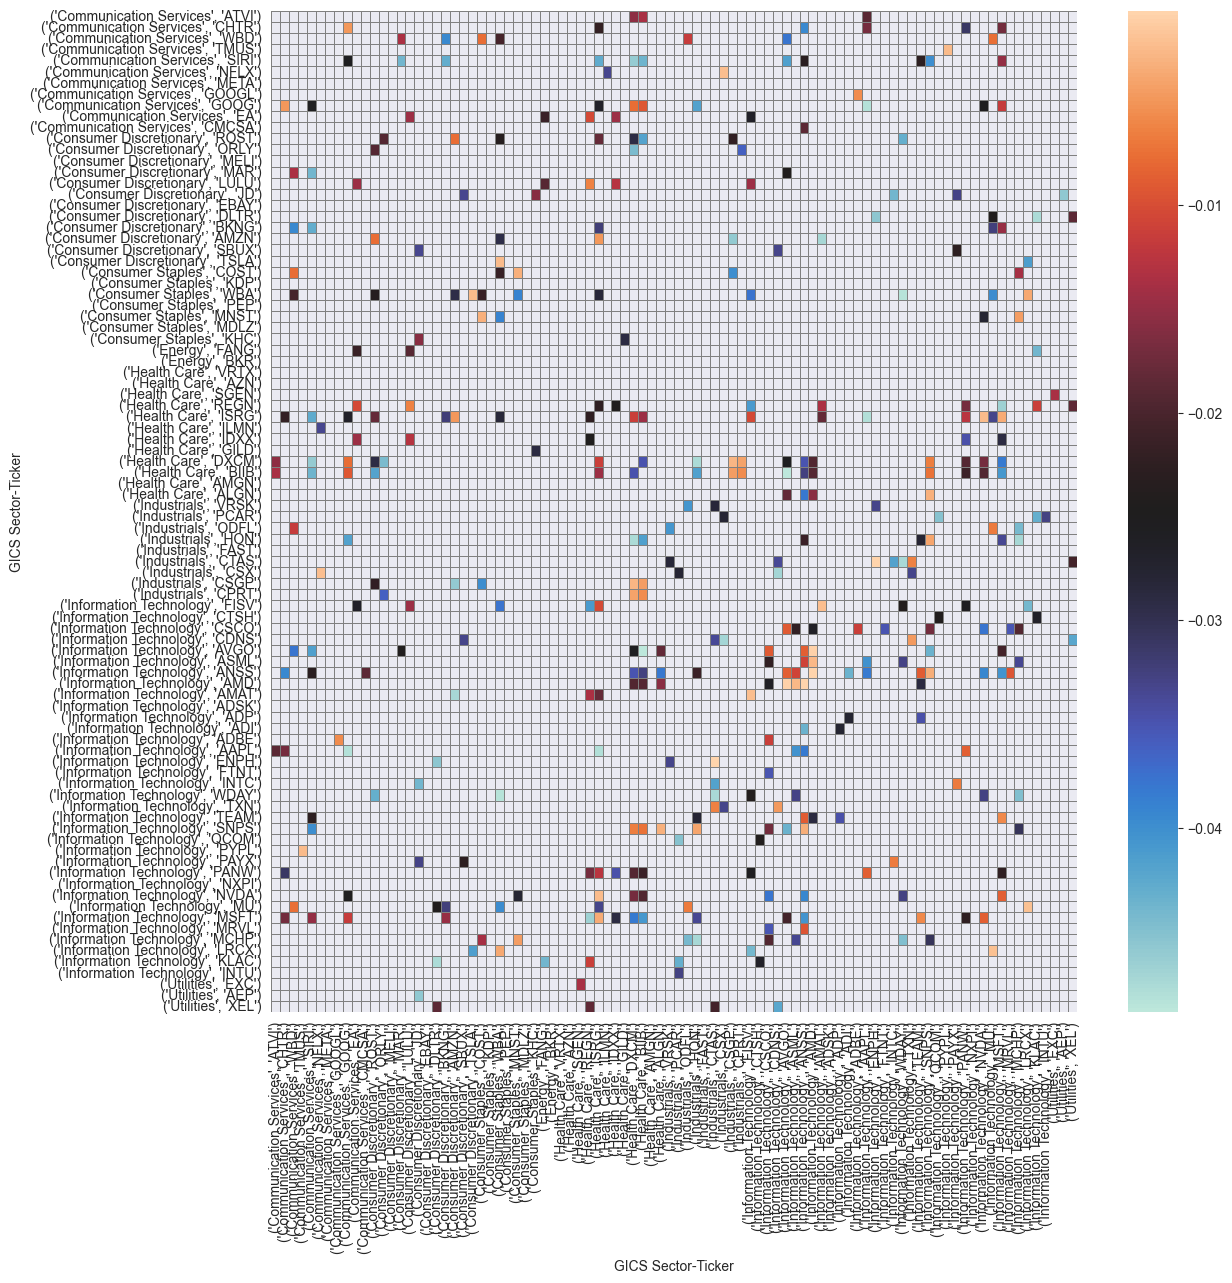

In [63]:
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(-stock_pvals, xticklabels=stock_pvals.columns, yticklabels=stock_pvals.columns, cmap='icefire', linecolor='grey', linewidth=0.5, mask = (stock_pvals >= 0.05))

# Trading & Evaluation Phase

Overview:

I will run a pairs trading strategy for a single pair at a time, selected as the top pairs with the most negative Dickey-Fuller statistic (lowest p-value) from the two-step Engle-Johanssen cointegration test.

Firstly, compute a spread (from a chosen pair) based off a (dynamic) hedge ratio via a Kalman filter. The Kalman filter is more responsive compared to a simple rolling regression.

 Then, convert this spread to a rolling window z-score (current value minus rolling mean divided by rolling standard deviation). Enter positions when this rolling z-score crosses upper or lower threshold, and exit when the z-score crosses 0.

Parameters are the window length $w_s$, $w_l$ involved in calculating the averages and standard deviation in the z-score, and threshold $[z, -z]$ to which we take positions. This determines the frequency of the trade. If it is too long, we make too few trades, if too short, we make too many and lose money to t-costs. 

In [55]:
def sharpe(return_series, n, rf):
    mean = (return_series.mean() * n) - rf
    sigma = return_series[30:].std() * np.sqrt(n) 
    return (mean/sigma).round(3)

def ir(return_series, bm_return, n):
    return_series = return_series - bm_return
    mean = (return_series.mean() * n)
    sigma = return_series[30:].std() * np.sqrt(n) 
    return (mean/sigma).round(3)


def KFHedgeRatio(x, y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return pd.DataFrame(state_means)[0]

def z_score(spread, s=5, l=30):
 
    l_spread = spread.rolling(window=l)
    s_spread = spread.rolling(window=s).mean()
    z_spread = s_spread.sub(l_spread.mean()).div(l_spread.std())
    return z_spread

def calc_spread(x, y):
    hr = KFHedgeRatio(x,y).values
    spread = y - hr * x
    return spread, hr

def create_df(x, y, s=5, l=30):

    spread, hr = calc_spread(x,y)
    z_spread = z_score(spread, s, l)
    
    df = pd.DataFrame({
                        f'y': y, 
                        f'x': x,
                        'hr': hr,
                        's' : spread,
                        'z': z_spread       
                    })
    df['trade_type'] = 0
    df['portfolio_val'] = 0

    return df
    
def simulate_trades(df, upper=0.5, lower=-0.5):
    holding, top_leg, bottom_leg, entries, exits = False, False, False, 0, 0
    for i in range(1, len(df)):
        if not holding:
            if df.z[i] >= upper:
                entry = df.y[i] - df.x[i] * df.hr[i] 
                holding, top_leg = True, True
                entries += 1
                df.iat[i, -2] = 'upper'
            elif df.z[i] <= lower: 
                entry = -(df.y[i] - df.x[i] * df.hr[i])
                holding, bottom_leg = True, True
                entries += 1
                df.iat[i, -2] = 'lower'
            else:
                entry = 0
            df.iat[i, -1] = entry
        else: 
            if top_leg == True and df.z[i] <= 0:
                exit =  -(df.y[i] - df.x[i] * df.hr[i])
                top_leg, holding = False, False
                df.iat[i, -2] = 'exit'
                exits += 1
            elif bottom_leg == True and df.z[i] >= 0:
                exit = (df.y[i] - df.x[i] * df.hr[i]) 
                bottom_leg, holding = False, False
                exits += 1
                df.iat[i, -2] = 'exit'
            else:
                exit = 0
            df.iat[i, -1] = exit 

    portfolio_val = (df.portfolio_val.cumsum()) + df.hr[0] * df.x[0]
    df.portfolio_val = portfolio_val
    rets = np.log(portfolio_val) - np.log(portfolio_val.shift(1))
    df['rets'] = rets
    df['cum_rets'] = rets.cumsum()

    print(f'Number of entry trades: {entries}')
    print(f'Number of exit trades: {exits}')
    print(f'Average time in days till entry or exit trade: {round(df.shape[0]/(entries+exits),3)}')

    return df, portfolio_val, rets


# Raw Performance

In [12]:
def test_sharpe_all_pairs(pairs, data, bm_rets, upper=0.5, lower=-0.5):
    sharpe_ratios, irs = [], []
    rets_df = pd.DataFrame(index=data.index)
    
    for pair in pairs.index.tolist():
        s1, s2 = pair.split()   
        df = create_df(data[s1], data[s2])
        _,_,rets = simulate_trades(df, upper=upper, lower=lower)
        sharpe_ratio = sharpe(rets, 252, 0.02)
        sharpe_ratios.append(sharpe_ratio)
        info_ratio = ir(rets, bm_rets, 252)
        irs.append(info_ratio)
        rets_df[pair] = rets
    
    sharpes = pd.DataFrame({'sharpe': sharpe_ratios, 'ir': irs}, index=pairs.index).sort_values(by='sharpe', ascending=False)
    rets_df = rets_df.fillna(0).cumsum()
    rets_df = rets_df[sharpes.index]
    
    return sharpes, rets_df


In [85]:
def raw_performance(stock_pairs, cutoff, stocks, ndx, in_sample=False):
    pairs = stock_pairs
    if cutoff <= 0.5:
        pairs = pairs[pairs.pval <= cutoff]
    else:
        pairs = pairs[pairs.pval >= cutoff]
    same_sector_pairs = pairs[pairs.left == pairs.right]
    sharpes, rets_df = test_sharpe_all_pairs(pairs, stocks, ndx)
    _sharpes, _rets_df = test_sharpe_all_pairs(same_sector_pairs, stocks, ndx)
    sharpes = sharpes.merge(stock_pairs, how='left', left_on=sharpes.index, right_on=stock_pairs.index)
    _sharpes = _sharpes.merge(stock_pairs, how='left', left_on=_sharpes.index, right_on=stock_pairs.index)
    sharpes.set_index('key_0', inplace=True)
    _sharpes.set_index('key_0', inplace=True)

    suffix, prefix = '', ''
    if in_sample:
        suffix = '_is'
    if cutoff >= 0.5:
        prefix = 'bad'

    sharpes.to_pickle(fr'data\{prefix}sharpes{suffix}')
    _sharpes.to_pickle(fr'data\{prefix}_sharpes{suffix}')
    rets_df.to_pickle(fr'data\{prefix}rets_df{suffix}')
    _rets_df.to_pickle(fr'data\{prefix}_rets_df{suffix}')

In [3]:
# raw_performance(stock_pairs, 0.10, oos_stocks, oos_ndx)
# raw_performance(stock_pairs, 0.10, is_stocks, is_ndx, in_sample=True)
# raw_performance(stock_pairs, 0.10, is_stocks, is_ndx, in_sample=True)
# raw_performance(stock_pairs, 0.80, oos_stocks, is_ndx, in_sample=True)

sharpes = pd.read_pickle(r'data\sharpes')
_sharpes = pd.read_pickle(r'data\_sharpes')
rets_df = pd.read_pickle(r'data\rets_df')
_rets_df = pd.read_pickle(r'data\_rets_df')
_rets_df_is = pd.read_pickle(r'data\_rets_df_is')

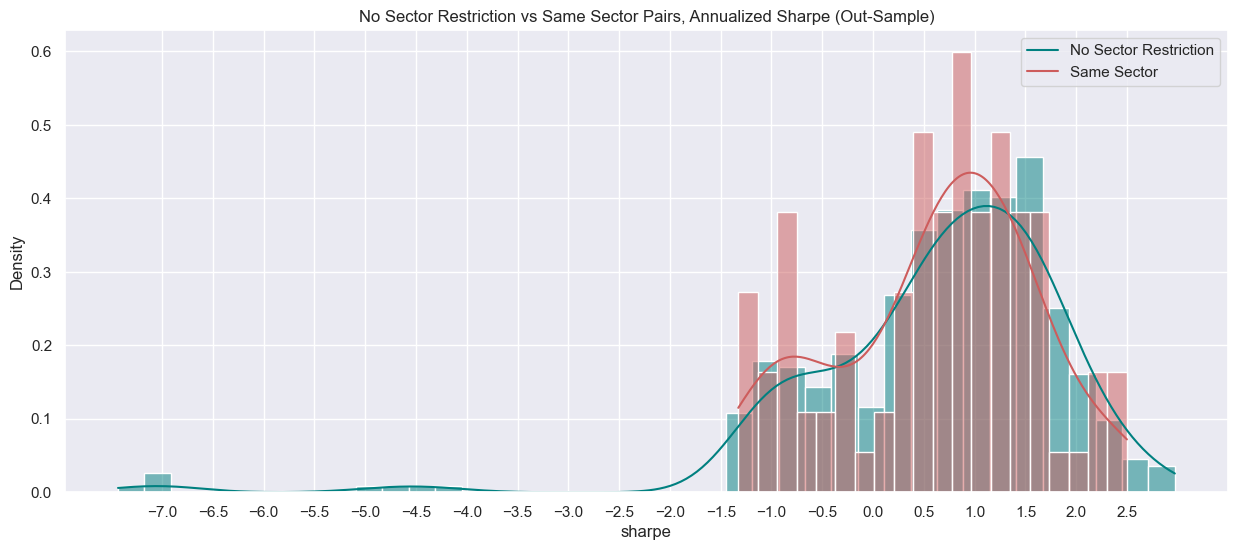

In [214]:
fig, ax = plt.subplots(figsize=(15,6))
sns.set_style('darkgrid')
ax.set_title('No Sector Restriction vs Same Sector Pairs, Annualized Sharpe (Out-Sample)')
ax.set_xticks(np.arange(sharpes.sharpe.min().round(0), sharpes.sharpe.max().round(0), 0.5))
sns.histplot(data=sharpes, x='sharpe', fill=True, color='teal', ax=ax, bins=40, alpha=0.5, kde=True, legend=True, stat='density')
sns.histplot(data=_sharpes, x='sharpe', fill=True, color='indianred', ax=ax, bins=20, alpha=0.5, kde=True, legend=True, stat='density')
plt.legend(['No Sector Restriction', 'Same Sector'])

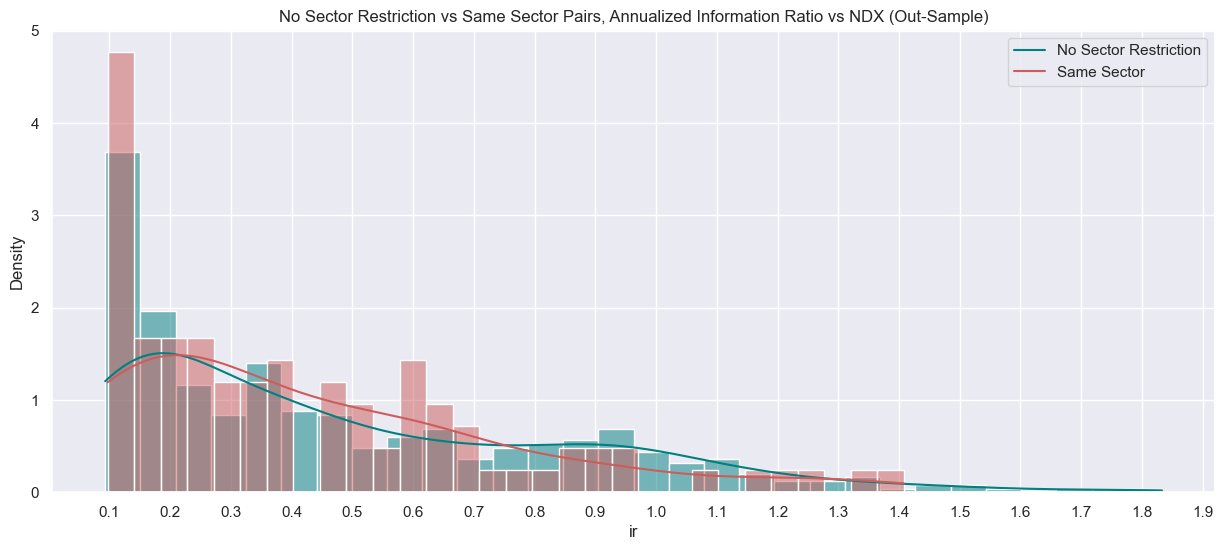

In [226]:
fig, ax = plt.subplots(figsize=(15,6))
sns.set_style('darkgrid')
ax.set_title('No Sector Restriction vs Same Sector Pairs, Annualized Information Ratio vs NDX (Out-Sample)')
ax.set_xticks(np.arange(sharpes.sharpe.min().round(0), sharpes.sharpe.max().round(0), 0.1))
sns.histplot(data=sharpes, x='ir', fill=True, color='teal', ax=ax, bins=30, alpha=0.5, kde=True, legend=True, stat='density')
sns.histplot(data=_sharpes, x='ir', fill=True, color='indianred', ax=ax, bins=30, alpha=0.5, kde=True, legend=True, stat='density')
plt.legend(['No Sector Restriction', 'Same Sector'])

In [8]:
sharpes.describe().round(3)

,sharpe,ir,pval
count,430.000,430.000,430.000
mean,0.624,0.482,0.051
std,1.322,0.367,0.029
min,-7.433,0.093,0.001
25%,0.057,0.172,0.025
50%,0.853,0.364,0.053
75%,1.464,0.729,0.076
max,2.971,1.833,0.100


In [9]:
_sharpes.describe().round(3)

,sharpe,ir,pval
count,96.000,96.000,96.000
mean,0.625,0.429,0.052
std,0.969,0.319,0.028
min,-1.327,0.097,0.003
25%,0.051,0.172,0.029
50%,0.805,0.350,0.055
75%,1.268,0.600,0.074
max,2.499,1.408,0.100


# Best vs Worst Pairs Analysis


# Single Pair


In [53]:
upper, lower = 0.5, -0.5
s1, s2 = 'INTC', 'QCOM'
df = create_df(oos_stocks[s1], oos_stocks[s2])
trades_df, portfolio_val, rets = simulate_trades(df, upper=upper, lower=lower)

Number of entry trades: 38
Number of exit trades: 37
Average time in days till entry or exit trade: 7.227


<AxesSubplot: title={'center': 'Normalized returns, INTL vs QCOM'}, xlabel='Date'>

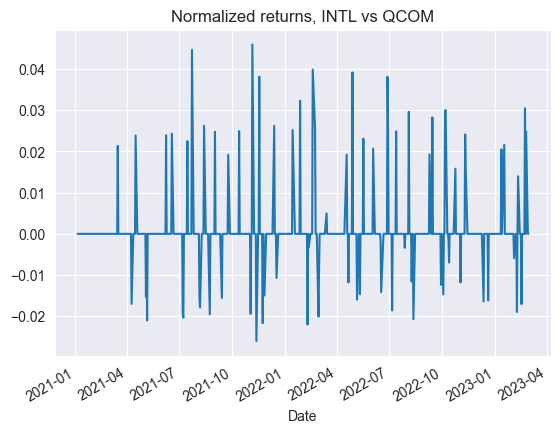

In [56]:
plt.title('Normalized returns, INTL vs QCOM')
rets.plot()

<AxesSubplot: title={'center': 'Equity curve, INTL vs QCOM'}, xlabel='Date'>

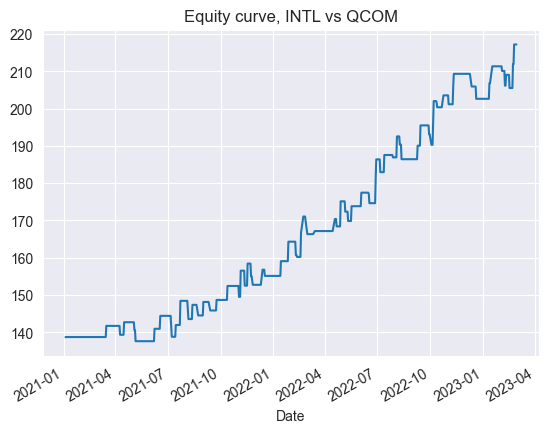

In [59]:
plt.title('Equity curve, INTL vs QCOM')
portfolio_val.plot()

In [24]:
trades_df.tail(15).round(3)

,y,x,hr,s,z,trade_type,portfolio_val,rets,cum_rets
Date,,,,,,,,,
2023-02-07,135.800,29.05,4.502,5.027,-0.366,0,210.090,0.000,0.415
2023-02-08,131.368,28.24,4.512,3.948,-0.506,lower,206.142,-0.019,0.396
2023-02-09,129.738,27.73,4.529,4.163,-0.111,0,206.142,0.000,0.396
2023-02-10,128.207,27.80,4.507,2.900,0.071,exit,209.043,0.014,0.410
2023-02-13,130.046,28.55,4.470,2.419,-0.123,0,209.043,0.000,0.410
2023-02-14,131.537,28.64,4.469,3.553,-0.306,0,209.043,0.000,0.410
2023-02-15,132.262,28.85,4.464,3.465,-0.434,0,209.043,0.000,0.410
2023-02-16,129.370,28.20,4.462,3.534,-0.542,lower,205.508,-0.017,0.393
2023-02-17,126.945,27.61,4.464,3.681,-0.497,0,205.508,0.000,0.393


In [25]:
fig = px.line(trades_df, x=trades_df.index, y=trades_df.columns[:2], title=f'Price comparison: {s1} vs {s2}', height=600)
fig.show()

In [27]:
upper_x = trades_df[trades_df.trade_type == 'upper'].index
upper_y = trades_df[trades_df.trade_type == 'upper'].s
lower_x = trades_df[trades_df.trade_type == 'lower'].index
lower_y = trades_df[trades_df.trade_type == 'lower'].s
mid_x = trades_df[trades_df.trade_type == 'exit'].index
mid_y = trades_df[trades_df.trade_type == 'exit'].s

In [28]:
trades = trades_df[trades_df.trade_type != 0]
x = trades.index
y = trades.s
color = trades.trade_type

In [29]:
fig = px.line(trades_df, x=trades_df.index, y=trades_df.s, title=f'Spread: {s1} vs {s2} with entry and exit points', height=600)
fig.add_trace(go.Scatter(x=upper_x, y=upper_y, marker=dict(size=10, symbol='triangle-down', line=dict(width=0.25, color='DarkSlateGrey')),
                    mode='markers', name='enter long leg'))
fig.add_trace(go.Scatter(x=lower_x, y=lower_y, marker=dict(size=10, symbol='triangle-up', line=dict(width=0.25, color='DarkSlateGrey')),
                    mode='markers', name='enter short leg'))
fig.add_trace(go.Scatter(x=mid_x, y=mid_y, marker=dict(size=7, symbol='circle', line=dict(width=0.25)),
                    mode='markers', name='exit'))
fig.show()

In [326]:
def plot_z_spread(df, s1, s2):
    fig = px.line(trades_df, x=trades_df.index, y='z', title=f'z-scored spread of {s1} vs {s2}', height=600)
    fig.add_hline(y=0.5, line_color='orange')
    fig.add_hline(y=-0.5, line_color='orange')
    fig.add_hline(y=0, line_color='red', line_dash='dash')
    fig.add_trace(go.Scatter(x=upper_x, y=upper_y, marker=dict(size=8, symbol='triangle-down', line=dict(width=0.25, color='DarkSlateGrey')),
                    mode='markers', name='enter long leg'))
    fig.add_trace(go.Scatter(x=lower_x, y=lower_y, marker=dict(size=8, symbol='triangle-up', line=dict(width=0.25, color='DarkSlateGrey')),
                    mode='markers', name='enter short leg'))
    fig.add_trace(go.Scatter(x=mid_x, y=mid_y, marker=dict(size=7, symbol='circle', line=dict(width=0.25)),
                    mode='markers', name='exit'))
    fig.show()

upper_x = trades_df[trades_df.trade_type == 'upper'].index
upper_y = trades_df[trades_df.trade_type == 'upper'].z
lower_x = trades_df[trades_df.trade_type == 'lower'].index
lower_y = trades_df[trades_df.trade_type == 'lower'].z
mid_x = trades_df[trades_df.trade_type == 'exit'].index
mid_y = trades_df[trades_df.trade_type == 'exit'].z

plot_z_spread(trades_df, s1, s2)

<AxesSubplot: title={'center': 'Cumulative Returns, Out-of-Sample'}, xlabel='Date'>

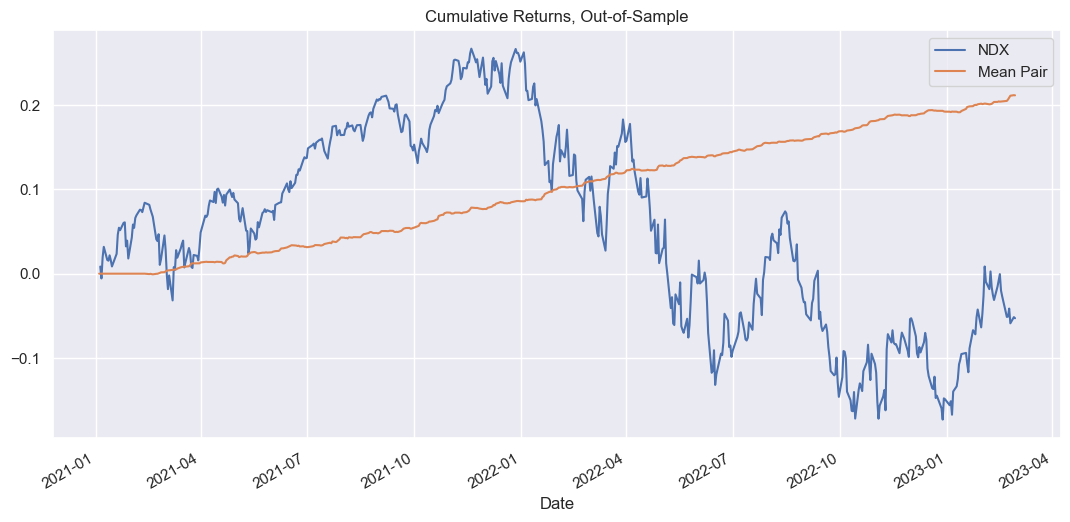

In [381]:
fig,ax = plt.subplots(figsize=(13,6))
ax.set_title('Cumulative Returns, Out-of-Sample')
plt.legend(['NDX'])
oos_benchmark = pd.concat([oos_ndx.cumsum(),_rets_df.mean(axis=1)], axis=1)
oos_benchmark.rename({'Adj Close': 'NDX', 0: 'Mean Pair'}, axis=1, inplace=True)
oos_benchmark.plot(ax=ax)


<AxesSubplot: title={'center': 'Cumulative Returns, In-Sample'}, xlabel='Date'>

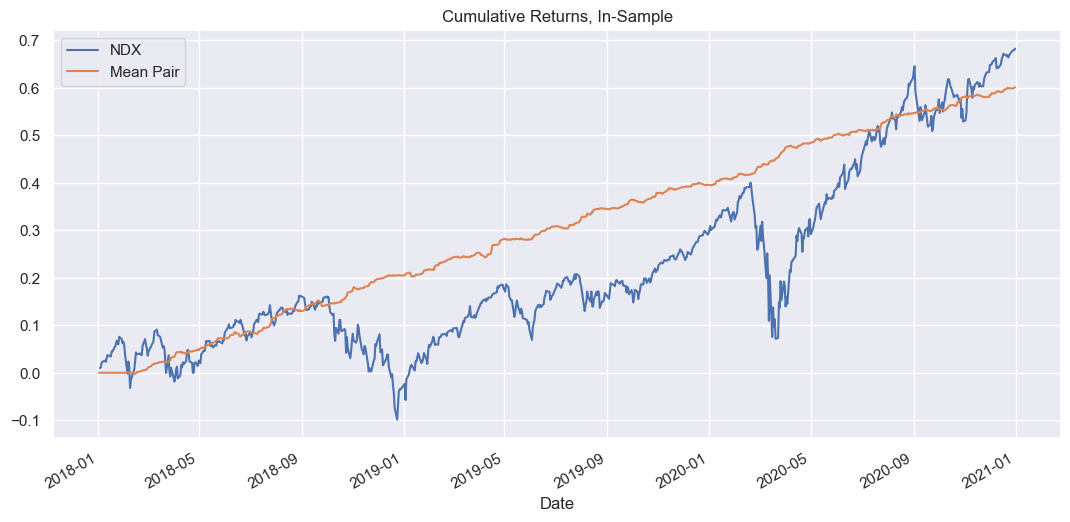

In [380]:
fig,ax = plt.subplots(figsize=(13,6))
ax.set_title('Cumulative Returns, In-Sample')
plt.legend(['NDX'])
is_benchmark = pd.concat([is_ndx.cumsum(),_rets_df_is.mean(axis=1)], axis=1)
is_benchmark.rename({'Adj Close': 'NDX', 0: 'Mean Pair'}, axis=1, inplace=True)
is_benchmark.plot(ax=ax)

# Cointegration & Returns Analysis

### Cointegration Trends By Sector

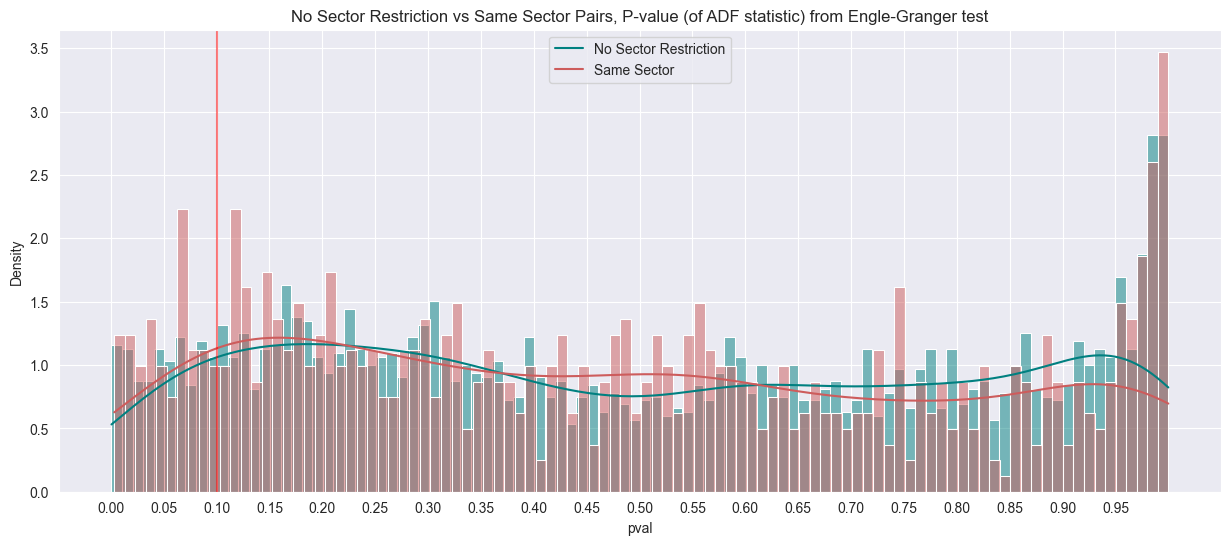

In [131]:
ss_pairs = stock_pairs[stock_pairs.left==stock_pairs.right]
ds_pairs = stock_pairs[stock_pairs.left!=stock_pairs.right]
fig, ax = plt.subplots(figsize=(15,6))
sns.set_style('darkgrid')
ax.set_xticks(np.arange(0,1, 0.05))
ax.set_title('No Sector Restriction vs Same Sector Pairs, P-value (of ADF statistic) from Engle-Granger test')
sns.histplot(data=ds_pairs, x='pval', fill=True, color='teal', ax=ax, bins=100, alpha=0.5, kde=True, legend=True, stat='density')
sns.histplot(data=ss_pairs, x='pval', fill=True, color='indianred', ax=ax, bins=100, alpha=0.5, kde=True, legend=True, stat='density')
plt.axvline(0.10, c='r', alpha=0.5)
plt.legend(['No Sector Restriction', 'Same Sector'])


<AxesSubplot: title={'center': 'Same Sector Pairs P-value by Sector'}, xlabel='pval', ylabel='left'>

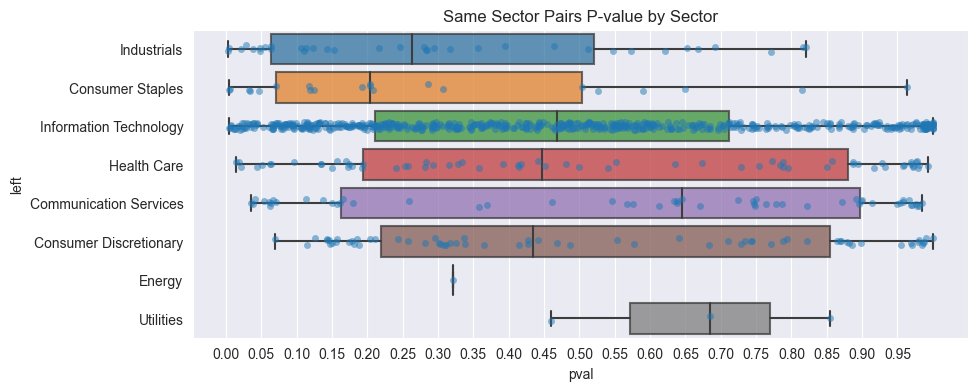

In [79]:

fig, ax = plt.subplots(figsize=(10,4))

sns.set_style('darkgrid')
ax.set_title('Same Sector Pairs P-value by Sector')

ax.set_xticks(np.arange(0,1, 0.05))
sns.boxplot(ss_pairs, x='pval', y='left', boxprops=dict(alpha=.75))
sns.stripplot(ss_pairs, x='pval', y='left', alpha=0.5)

<AxesSubplot: title={'center': 'Same Sector Pairs P-value by Sector'}, xlabel='ir', ylabel='left'>

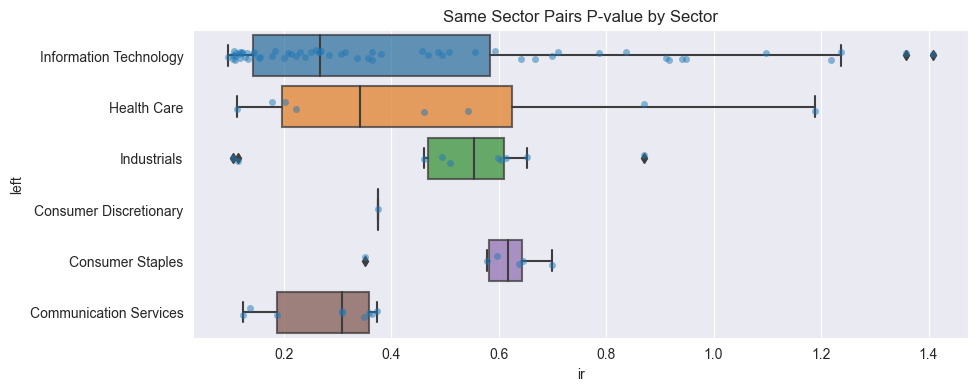

In [143]:

fig, ax = plt.subplots(figsize=(10,4))

sns.set_style('darkgrid')
ax.set_title('Same Sector Pairs P-value by Sector')

sns.boxplot(_sharpes, x='ir', y='left', boxprops=dict(alpha=.75))
sns.stripplot(_sharpes, x='ir', y='left', alpha=0.5)

### Cointegration as an Alpha Factor

* Describe, then plot.
* Take good and bad sharpes/ir, plot pval vs sharpe/ir on same plot

In [138]:

sharpes_is = pd.read_pickle(r'data\sharpes_is')
_sharpes_is = pd.read_pickle(r'data\_sharpes_is')
rets_df_is = pd.read_pickle(r'data\rets_df_is')
_rets_df_is = pd.read_pickle(r'data\_rets_df_is')

badsharpes_is = pd.read_pickle(r'data\badsharpes_is')
bad_sharpes_is = pd.read_pickle(r'data\bad_sharpes_is')
badrets_df_is = pd.read_pickle(r'data\badrets_df_is')
bad_rets_df_is = pd.read_pickle(r'data\bad_rets_df_is')

all_pairs_comp = pd.concat([badsharpes_is, sharpes_is])
ss_comp = pd.concat([bad_sharpes_is, _sharpes_is])


<AxesSubplot: title={'center': '(In-sample) Same Sector Pairs Cointegration (p-value) versus Sharpe, Spearman: -0.361 | Pearson: -0.413'}, xlabel='pval', ylabel='sharpe'>

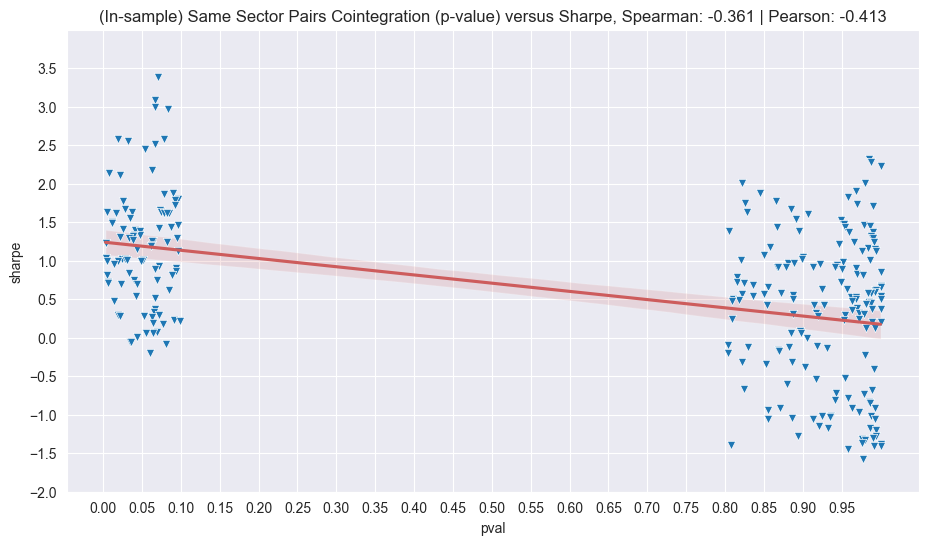

In [71]:
fig, ax = plt.subplots(figsize=(11,6))
sns.set_style('darkgrid')
ax.set_xticks(np.arange(0,1, 0.05))
ax.set_yticks(np.arange(-2,4, 0.5))
ax.set_ylim(-2.0,4)
ax.set_title('(In-sample) Same Sector Pairs Cointegration (p-value) versus Sharpe, Spearman: -0.361 | Pearson: -0.413')
sns.regplot(data=ss_comp, y='sharpe', x='pval',  scatter_kws={"color": "black", "alpha":0}, line_kws={"color": "indianred"})
sns.scatterplot(data=ss_comp, y='sharpe', x='pval', marker='v')


In [188]:

print(f"Spearman coefficient: {s.spearmanr(ss_comp.sharpe, ss_comp.pval).statistic.round(3)}")
print(f"Pearson coefficient: {s.pearsonr(ss_comp.sharpe, ss_comp.pval).statistic.round(3)}")

Spearman coefficient: -0.361
Pearson coefficient: -0.413


### Transfer Coefficient of Cointegration In-Sample to Out-Sample


In [124]:
ss_sorted_is_pval = stock_pairs.loc[stock_pairs.index.sort_values(),:][stock_pairs.left==stock_pairs.right][['pval', 'left']]
ss_sorted_oos_pval = _stock_pairs.loc[_stock_pairs.index.sort_values(),:][_stock_pairs.left==_stock_pairs.right][['pval', 'left']]
ss_pvals = pd.DataFrame({'is_pval':ss_sorted_is_pval.pval, 'oos_pval':ss_sorted_oos_pval.pval, 'sector':ss_sorted_is_pval.left})
# ss_pvals = ss_pvals[ss_pvals.is_pval <= 0.10]

<AxesSubplot: title={'center': 'In-sample p-values vs out-sample p-values (same sector pairs)'}, xlabel='is_pval', ylabel='oos_pval'>

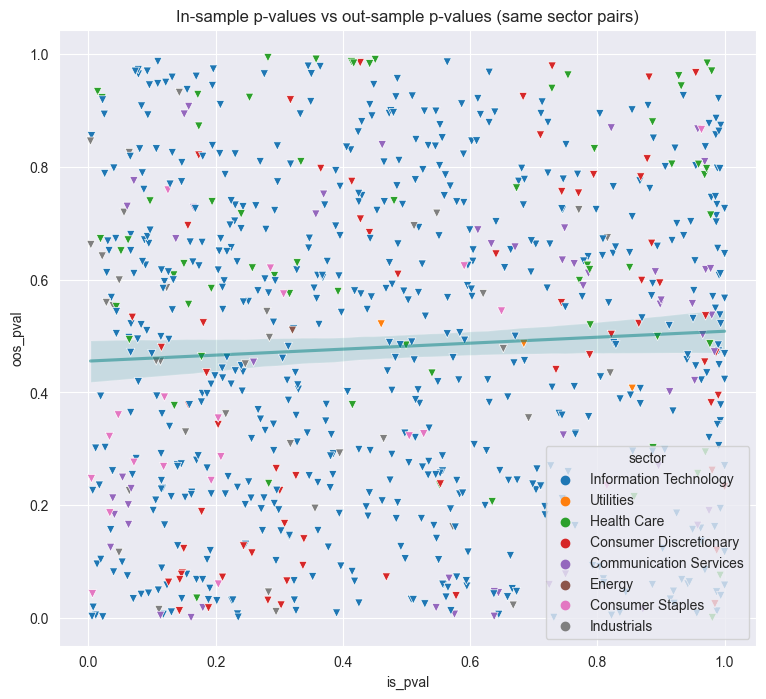

In [148]:
fig, ax = plt.subplots(figsize=(9,8))
sns.set_style('darkgrid')
ax.set_title('In-sample p-values vs out-sample p-values (same sector pairs)')
sns.regplot(data=ss_pvals, y='oos_pval', x='is_pval',  scatter_kws={"color": "black", "alpha":0}, line_kws={"color": "teal", "alpha":0.5})
sns.scatterplot(data=ss_pvals, y='oos_pval', x='is_pval', marker='v', hue='sector')


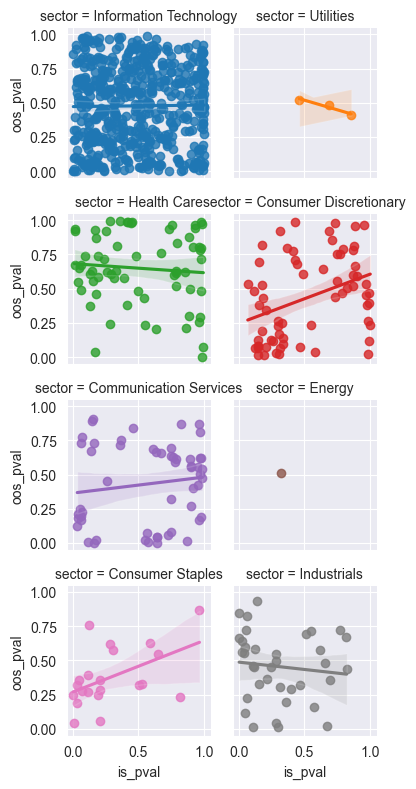

In [145]:
sns.lmplot(data=ss_pvals, y='oos_pval', x='is_pval', hue='sector', col='sector', col_wrap=2, height=2)


In [85]:
_stock_pairs

,pval,left,right
EA PYPL,0.000137,Communication Services,Information Technology
ASML ISRG,0.000205,Information Technology,Health Care
CSX NVDA,0.000262,Industrials,Information Technology
ADBE EBAY,0.000302,Information Technology,Consumer Discretionary
META VRTX,0.000456,Communication Services,Health Care
...,...,...,...
GILD ODFL,0.992922,Health Care,Industrials
GILD MCHP,0.993155,Health Care,Information Technology
GILD TXN,0.993924,Health Care,Information Technology
GILD NXPI,0.993927,Health Care,Information Technology


In [60]:
pvals

,is_pval,oos_pval
AAPL ADSK,0.075075,0.282793
AAPL AMD,0.078486,0.418943
AAPL GOOG,0.015340,0.653787
AAPL GOOGL,0.013665,0.652356
AAPL ISRG,0.051376,0.537363
...,...,...
SIRI WBA,0.075261,0.002214
SNPS TMUS,0.008592,0.437164
TEAM TMUS,0.063563,0.403869
TEAM VRSK,0.002102,0.484399
